<a href="https://colab.research.google.com/github/kurokawa5/kaggle_practice/blob/main/titanic/kaggle_titanic_ch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import numpy as np
import pandas as pd

In [44]:
# トレーニングデータ、テストデータ、サンプルサブミットデータを読み込み
train = pd.read_csv('/content/drive/MyDrive/05_workspace/05_kaggle/01_titanic/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/05_workspace/05_kaggle/01_titanic/titanic/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/05_workspace/05_kaggle/01_titanic/titanic/gender_submission.csv')

In [45]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
# SexとEmbarkedのOne-Hotエンコーディング
train = pd.get_dummies(train, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])

# 不要な列の削除
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

# trainの表示
display(train.head())

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [47]:
X_train = train.drop(['Survived'], axis=1)  # X_trainはtrainのSurvived列以外
y_train = train['Survived']  # Y_trainはtrainのSurvived列

In [48]:
display(X_train.head())

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [49]:
display(y_train.head())

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [50]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# X_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

In [51]:
X_train.shape

(891, 10)

In [52]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((596, 10), (295, 10), (596,), (295,))

In [53]:
# lab.Datasetでtrainとvalidを作っておく
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y)

# パラメータを定義
lgbm_params = {'objective': 'binary'}

# lgb.trainで学習
evals_result = {}
gbm = lgb.train(params = lgbm_params,
                train_set = lgb_train,
                valid_sets= [lgb_train, lgb_eval],
                early_stopping_rounds=20,
                evals_result=evals_result,
                verbose_eval=10);

Training until validation scores don't improve for 20 rounds.
[10]	training's binary_logloss: 0.426533	valid_1's binary_logloss: 0.465153
[20]	training's binary_logloss: 0.350077	valid_1's binary_logloss: 0.419539
[30]	training's binary_logloss: 0.303469	valid_1's binary_logloss: 0.40614
[40]	training's binary_logloss: 0.268824	valid_1's binary_logloss: 0.402566
[50]	training's binary_logloss: 0.241557	valid_1's binary_logloss: 0.409918
[60]	training's binary_logloss: 0.220422	valid_1's binary_logloss: 0.415006
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.268824	valid_1's binary_logloss: 0.402566


In [54]:
# valid_xについて推論
oof = (gbm.predict(valid_x) > 0.5).astype(int)
print('score', round(accuracy_score(valid_y, oof)*100,2)) 

score 81.69


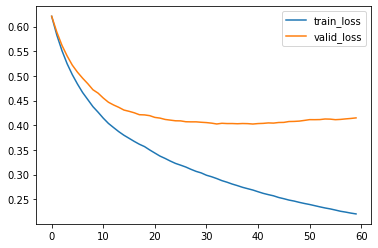

In [55]:
import matplotlib.pyplot as plt

plt.plot(evals_result['training']['binary_logloss'], label='train_loss')
plt.plot(evals_result['valid_1']['binary_logloss'], label='valid_loss')
plt.legend()

In [56]:
valid_x

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
495,3,NaN,0,0,14.4583,0,1,1,0,0
648,3,NaN,0,0,7.5500,0,1,0,0,1
278,3,7.0,4,1,29.1250,0,1,0,1,0
31,1,NaN,1,0,146.5208,1,0,1,0,0
255,3,29.0,0,2,15.2458,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
17,2,NaN,0,0,13.0000,0,1,0,0,1
476,2,34.0,1,0,21.0000,0,1,0,0,1
533,3,NaN,0,2,22.3583,1,0,1,0,0
416,2,34.0,1,1,32.5000,1,0,0,0,1


In [57]:
(gbm.predict(valid_x) > 0.5).astype(int)

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1])

In [58]:
#evals_result

In [59]:
test_pred = (gbm.predict(test) > 0.5).astype(int)
sample_submission['Survived'] = test_pred
sample_submission.to_csv('/content/drive/MyDrive/05_workspace/05_kaggle/01_titanic/titanic/output/train_test_split.csv', index=False) 

In [63]:
# 3分割交差検証を指定し、インスタンス化
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=0)

# スコアとモデルを格納するリスト
score_list = []
models = []

In [64]:
for fold_, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):    
    print(f'fold{fold_ + 1} start')
    train_x = X_train.iloc[train_index]
    valid_x = X_train.iloc[valid_index]
    train_y = y_train[train_index]
    valid_y = y_train[valid_index]

    # lab.Datasetを使って、trainとvalidを作っておく
    lgb_train= lgb.Dataset(train_x, train_y)
    lgb_valid = lgb.Dataset(valid_x, valid_y)

    # パラメータを定義
    lgbm_params = {'objective': 'binary'}

    # lgb.trainで学習
    gbm = lgb.train(params=lgbm_params,
                    train_set=lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    early_stopping_rounds=20,
                    verbose_eval=-1
                    )
    oof = (gbm.predict(valid_x) > 0.5).astype(int)
    score_list.append(round(accuracy_score(valid_y, oof)*100,2))
    models.append(gbm)  # 学習が終わったモデルをリストに入れておく
    print(f'fold{fold_ + 1} end\n' )
print(score_list, '平均score', round(np.mean(score_list), 2))

fold1 start
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.312807	valid_1's binary_logloss: 0.404449
fold1 end

fold2 start
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.286703	valid_1's binary_logloss: 0.39583
fold2 end

fold3 start
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.289415	valid_1's binary_logloss: 0.451098
fold3 end

[81.82, 84.51, 78.79] 平均score 81.71


In [70]:
models

In [71]:
# テストデータの予測を格納する、418行3列のnumpy行列を作成
test_pred = np.zeros((len(test), 3))

for fold_, gbm in enumerate(models):
    print(fold_)
    print(gbm)
    test_pred[:, fold_] = gbm.predict(test) # testを予測

pred = (np.mean(test_pred, axis=1) > 0.5).astype(int)
sample_submission['Survived'] = pred
sample_submission.to_csv('/content/drive/MyDrive/05_workspace/05_kaggle/01_titanic/titanic/output/3-fold_cross-validation.csv',index=False)

0
1
2
